# Konwolucyjne Sieci Neuronowe
## Importy
+ Główną biblioteką do wykorzystania do klasyfikacji obrazów jest torchvision, torch rozpoczyna swoje operacje od momentu kiedy obrazy przetwarzane są w tensory, ale wcześniej odwołuje się też do innych bibliotek takich jak Pillow czy OpenCV.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()

True

## Zbiory danych
+ Razem z torchvision dostępne są standardowo wykorzystywane zbiory danych. Na potrzeby dzisiejszych ćwiczeń skorzystamy ze zbioru CIFAR-10

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


+ Wyświetlenie obrazków:

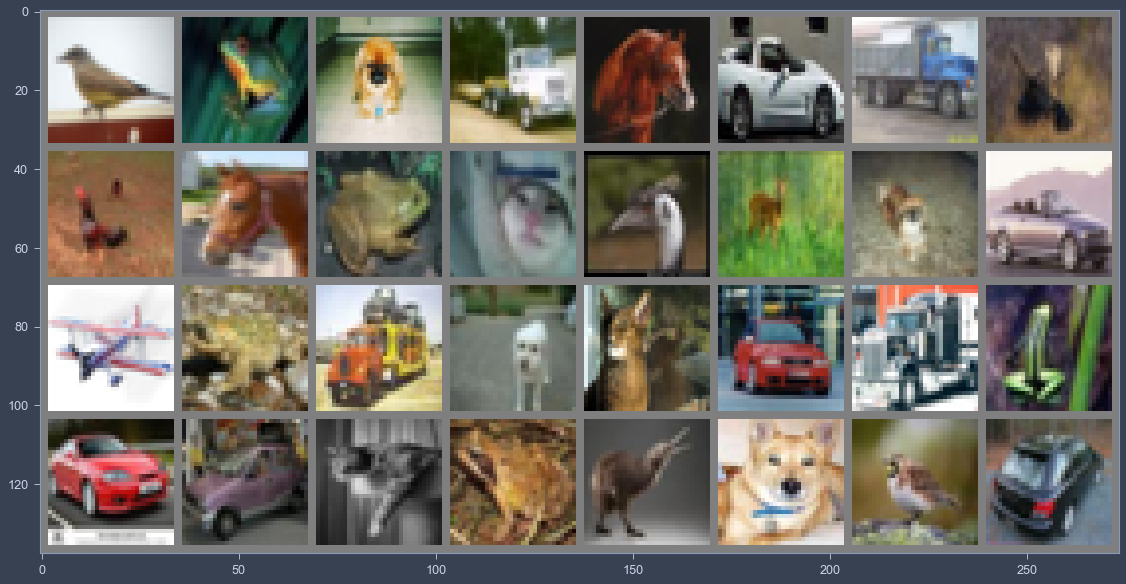

 bird  frog   dog truck horse   car truck  deer  bird horse  frog   cat  bird  deer   dog   car plane  frog truck   dog   cat   car truck  frog   car   car   cat  frog  bird   dog  bird   car


In [15]:
plt.figure(figsize = (20,10))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Parametry warstw sieci konwolucyjnej

+ Wejście, zwróćmy uwagę na to, jaka jest kolejność wymiarów: [batch_size, channels, height, width]

In [16]:
images[0:1].size()

torch.Size([1, 3, 32, 32])

+ conv zmniejsza wymiarowość na height i width w zależności od rozmiaru filtru:

In [17]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=0).to(device)
conv1(images[0:1].to(device)).size()

torch.Size([1, 6, 28, 28])

+ stride = krok > 1:

In [18]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), stride=(2,2), padding=0).to(device)
conv1(images[0:1].to(device)).size()

torch.Size([1, 6, 14, 14])

+ dodatkowy padding:

In [19]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=1).to(device)
conv1(images[0:1].to(device)).size()

torch.Size([1, 6, 30, 30])

+ filtry nie będące kwadratowymi:

In [20]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,2), stride=(1,1), padding=0).to(device)
conv1(images[0:1].to(device)).size()

torch.Size([1, 6, 28, 31])

+ jak działa padding:

In [21]:
conv1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,3), stride=(3,2), padding=(2,2), padding_mode='zeros').to(device)
out = conv1(images[0:1].to(device))
print(out.size())
out

torch.Size([1, 1, 11, 17])


tensor([[[[ 0.1235, -0.2735, -0.2871, -0.2949, -0.3024, -0.3062, -0.3124,
           -0.3085, -0.3101, -0.3054, -0.2918, -0.2864, -0.2716, -0.2525,
           -0.2326, -0.2134, -0.2880],
          [ 0.0979, -0.1550, -0.1622, -0.1636, -0.1593, -0.1595, -0.1658,
           -0.1664, -0.1656, -0.1642, -0.1598, -0.1581, -0.1484, -0.1443,
           -0.1389, -0.1220, -0.1967],
          [ 0.0985, -0.1636, -0.1922, -0.3659, -0.1624, -0.1241, -0.1669,
           -0.1710, -0.1710, -0.1679, -0.1707, -0.1639, -0.1539, -0.1518,
           -0.1358, -0.1281, -0.2078],
          [ 0.1029, -0.2202,  0.0986,  0.3525,  0.2446,  0.1112, -0.0475,
           -0.1627, -0.1645, -0.1649, -0.1666, -0.1669, -0.1598, -0.1492,
           -0.1411, -0.1383, -0.2107],
          [ 0.0997, -0.1401, -0.2343, -0.4265, -0.2083, -0.1586, -0.1038,
            0.0310, -0.0628, -0.1704, -0.1645, -0.1695, -0.1552, -0.1484,
           -0.1442, -0.1317, -0.2159],
          [ 0.1028, -0.1611, -0.1656, -0.1633, -0.0358,  0.0095, 

In [22]:
list(conv1.parameters())

[Parameter containing:
 tensor([[[[ 0.1275, -0.0346,  0.0622],
           [ 0.0554, -0.0896, -0.1000],
           [-0.1460, -0.0493,  0.0002],
           [-0.0283, -0.0498, -0.1490],
           [-0.0763,  0.1084,  0.0632]],
 
          [[ 0.0301,  0.1194,  0.1033],
           [-0.0843,  0.1347, -0.0289],
           [ 0.1251, -0.0908,  0.0255],
           [ 0.0750, -0.1424, -0.0214],
           [-0.0008, -0.0192,  0.0496]],
 
          [[ 0.0800, -0.1163, -0.1283],
           [-0.0008, -0.0070,  0.0479],
           [ 0.1206, -0.0008, -0.0432],
           [-0.1433, -0.1236,  0.1209],
           [ 0.0787, -0.1441,  0.1443]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0388], device='cuda:0', requires_grad=True)]

+ Pooling  czyli warstwa uśredniająca:

In [23]:
images[0:1].size()

torch.Size([1, 3, 32, 32])

In [24]:
pool1 = nn.MaxPool2d(kernel_size=2).to(device)
pool1(images[0:1].to(device)).size()

torch.Size([1, 3, 16, 16])

+ domyślnie stride = kernel_size:

In [25]:
pool1 = nn.MaxPool2d(kernel_size=2,stride=(2,2)).to(device)
pool1(images[0:1].to(device)).size()

torch.Size([1, 3, 16, 16])

In [26]:
pool1 = nn.MaxPool2d(kernel_size=2,stride=1).to(device)
pool1(images[0:1].to(device)).size()

torch.Size([1, 3, 31, 31])

+ Max pooling:

In [27]:
mini_example = images[0:1,0,0:4,0:4]
mini_example

tensor([[[0.7176, 0.7255, 0.7412, 0.7569],
         [0.7569, 0.7647, 0.7882, 0.8039],
         [0.7569, 0.7647, 0.7882, 0.8039],
         [0.7804, 0.7882, 0.8118, 0.8196]]])

In [28]:
pool1 = nn.MaxPool2d(kernel_size=2).to(device)
pool1(mini_example.to(device))

tensor([[[0.7647, 0.8039],
         [0.7882, 0.8196]]], device='cuda:0')

+ Avarage pooling:

In [29]:
pool1 = nn.AvgPool2d(kernel_size=2).to(device)
pool1(mini_example.to(device))

tensor([[[0.7412, 0.7725],
         [0.7725, 0.8059]]], device='cuda:0')

## Trenowanie sieci konwolucyjnej

In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=35, kernel_size=(5,5), stride=(1,1), padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=35, out_channels=20, kernel_size=(3,3))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=(2,2))
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=8, kernel_size=(3,3))
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32, 120)
        self.fc2 = nn.Linear(120, 30)
        self.fc3 = nn.Linear(30, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 35, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(35, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=10, bias=True)
)

In [62]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [32]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1/5] loss: 1.309
[2/5] loss: 1.081
[3/5] loss: 0.969
[4/5] loss: 0.904
[5/5] loss: 0.858
Finished Training


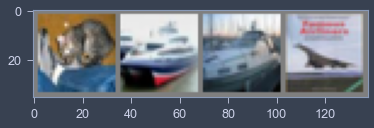

GroundTruth:    cat  ship  ship plane


In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [34]:
outputs = net(images.to(device))
outputs

tensor([[-0.4334, -2.2516,  0.0817,  1.7823, -1.9830,  0.9474, -0.5512, -1.2711,
          0.8415, -0.9842],
        [ 3.2400,  6.0364, -2.6923, -3.1345, -4.8969, -5.5590, -5.3032, -5.4290,
          5.8656,  3.5176],
        [ 1.1383,  3.8299, -1.5851, -1.1812, -3.1701, -2.6624, -2.6325, -2.5086,
          2.9902,  2.3682],
        [ 4.0070, -0.4698,  0.3081, -1.1866, -2.1537, -3.3891, -4.7160, -3.7850,
          5.4203, -0.6732]], device='cuda:0', grad_fn=<AddmmBackward>)

In [35]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [37]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data    
        images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 45.1 %
Accuracy for class car   is: 68.7 %
Accuracy for class bird  is: 36.8 %
Accuracy for class cat   is: 33.1 %
Accuracy for class deer  is: 43.7 %
Accuracy for class dog   is: 58.7 %
Accuracy for class frog  is: 80.6 %
Accuracy for class horse is: 75.4 %
Accuracy for class ship  is: 73.9 %
Accuracy for class truck is: 75.3 %


## Data augmentation

In [38]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


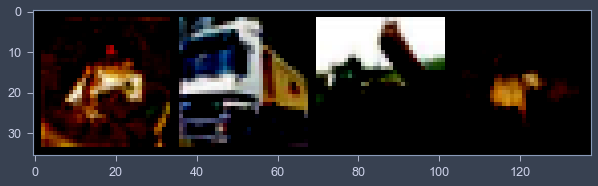

 frog truck truck  deer


In [39]:
plt.figure(figsize = (10,7))
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [40]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

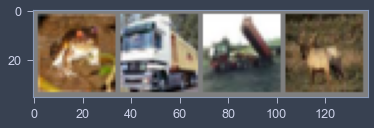

In [41]:
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

+ Center crop:

Files already downloaded and verified


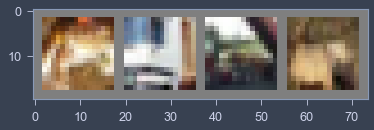

In [42]:
transform = transforms.Compose(
    [transforms.CenterCrop(16),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

+ Random crop:

Files already downloaded and verified


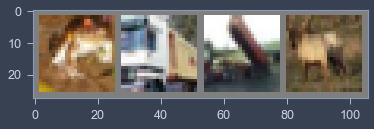

In [43]:
transform = transforms.Compose(
    [transforms.RandomCrop(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

+ Random horizontal crop:

Files already downloaded and verified


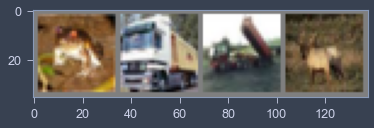

In [44]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

+ Random verticalal flip:

Files already downloaded and verified


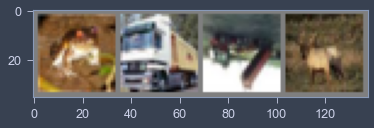

In [45]:
transform = transforms.Compose(
    [transforms.RandomVerticalFlip(0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

+ Random rotation:

Files already downloaded and verified


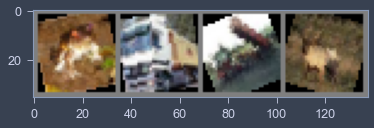

In [46]:
transform = transforms.Compose(
    [transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

+ Random erasing:

Files already downloaded and verified


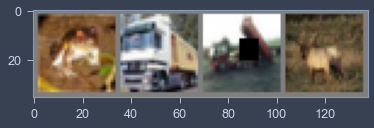

In [47]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

+ Połączenie w całość:

Files already downloaded and verified


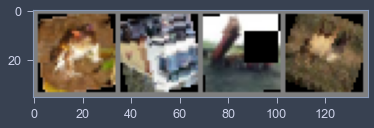

In [48]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

In [49]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [50]:
net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 35, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(35, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=10, bias=True)
)

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [52]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1/5] loss: 1.371
[2/5] loss: 1.180
[3/5] loss: 1.118
[4/5] loss: 1.076
[5/5] loss: 1.037
Finished Training


In [53]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


+ Zwiekszenie liczby epok:

In [54]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/10] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1/10] loss: 1.016
[2/10] loss: 0.994
[3/10] loss: 0.980
[4/10] loss: 0.966
[5/10] loss: 0.961
[6/10] loss: 0.948
[7/10] loss: 0.938
[8/10] loss: 0.929
[9/10] loss: 0.911
[10/10] loss: 0.901
Finished Training


In [55]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


## Współcześnie stosowane modele

In [4]:
import torchvision.models as models
resnet18 = models.resnet18()

In [57]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

+ porównanie liczby parametrów:

In [58]:
params_sum = 0
for params in net.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

18328

In [59]:
params_sum = 0
for params in resnet18.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

11689512

In [60]:
densenet = models.densenet161()

In [61]:
params_sum = 0
for params in densenet.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

28681000

In [62]:
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## Zanikanie gradientu
+ Gradienty zachowuja sie inaczej na poczatku sieci niz na koncu - na koncu sieci gradienty są wieksze niz na poczatku:

In [63]:
import torch.nn as nn


class LongNet(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.n_convs =  20
        n_channels = 10
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(5,5), stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding=0)

        self.convs = [nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding=2) for _ in range(self.n_convs)]
        self.bns = [nn.BatchNorm2d(n_channels) for _ in range(self.n_convs)]
     
        ## Warstwa max pooling 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=(2,2))

        self.fc1 = nn.Linear(n_channels * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        for i in range(self.n_convs):
            x = F.relu(self.convs[i](x))
            x = self.bns[i](x)
        x = self.pool1(x)
#         print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


long_net = LongNet().to(device)
for conv in long_net.convs:
    conv.to(device)
for bn in long_net.bns:
    bn.to(device)
long_net

LongNet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1440, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(long_net.parameters(), lr=0.001)

[1/5] loss: 1.705


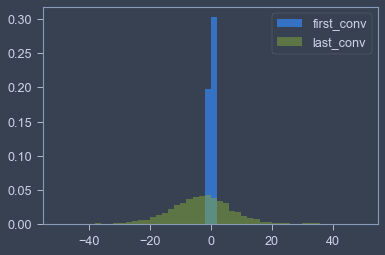

[2/5] loss: 1.630


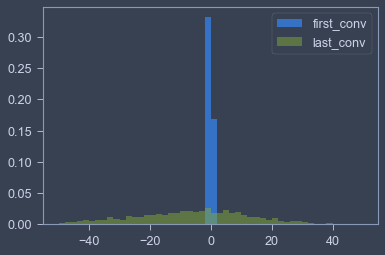

[3/5] loss: 1.598


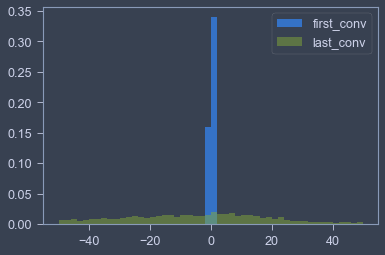

[4/5] loss: 1.601


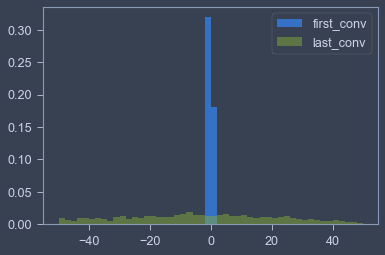

[5/5] loss: 1.602


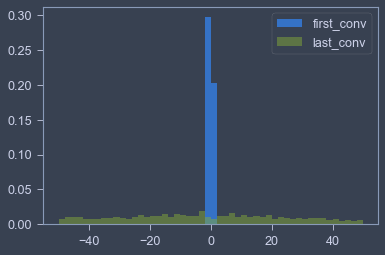

Finished Training


In [65]:
n_epochs = 5
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = long_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/%d] loss: %.3f' %
          (epoch+1 , n_epochs, running_loss / 2000))
    running_loss = 0.0
#     pd.DataFrame(long_net.conv1.weight.grad.cpu().detach().numpy().reshape(-1)).hist(bins=30)
    plt.hist(long_net.conv1.weight.grad.cpu().detach().numpy().reshape(-1),bins=50, label="first_conv",density=True,range=[-50,50])
    plt.hist(long_net.convs[9].weight.grad.cpu().detach().numpy().reshape(-1),bins=50, alpha=0.5, label="last_conv",density=True,range=[-50,50])
    plt.legend(loc='upper right')
    plt.show()
    plt.close()
    

print('Finished Training')

+ Skip connection - jak mamy duzo warstw, to mozemy stworzyc pojedyncze polaczenia pomijajace konkretne wagi bo krok jest małym ułamkiem:

In [16]:
import torch.nn as nn
import torch.nn.functional as F


class LongNet(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.n_convs =  20
        n_channels = 10
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(5,5), stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding=0)
        self.convs = [nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=(5,5), stride=1, padding=2) for _ in range(self.n_convs)]
        self.bns = [nn.BatchNorm2d(n_channels) for _ in range(self.n_convs)]
     
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=(2,2))

        self.fc1 = nn.Linear(n_channels * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x_2 = F.relu(self.conv2(x))
        x = x_2
        
        #sztuczne doklejanie
        
        for i in range(self.n_convs):
            x = torch.cat([x,x_2],dim=1)
            x = F.relu(self.convs[i](x))
            x = self.bns[i](x)
        x = self.pool1(x)
#         print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


long_net = LongNet().to(device)
for conv in long_net.convs:
    conv.to(device)
for bn in long_net.bns:
    bn.to(device)
long_net

LongNet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1440, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

[1/5] loss: 1.816


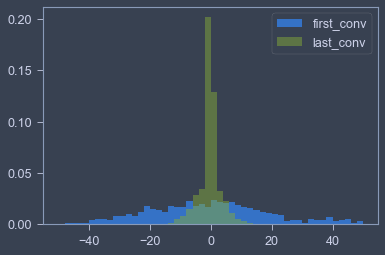

[2/5] loss: 1.816


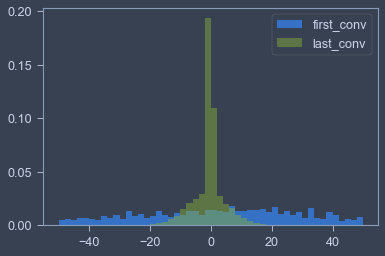

[3/5] loss: 1.816


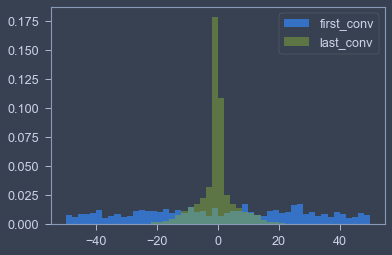

[4/5] loss: 1.816


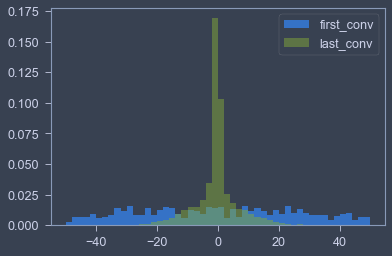

[5/5] loss: 1.816


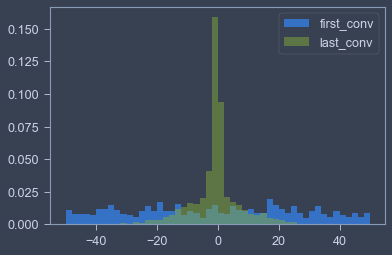

Finished Training


In [84]:
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = long_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/%d] loss: %.3f' %
          (epoch+1 , n_epochs, running_loss / 2000))
    running_loss = 0.0
#     pd.DataFrame(long_net.conv1.weight.grad.cpu().detach().numpy().reshape(-1)).hist(bins=30)
    plt.hist(long_net.conv1.weight.grad.cpu().detach().numpy().reshape(-1),bins=50, label="first_conv",density=True,range=[-50,50])
    plt.hist(long_net.convs[9].weight.grad.cpu().detach().numpy().reshape(-1),bins=50, alpha=0.5, label="last_conv",density=True,range=[-50,50])
    plt.legend(loc='upper right')
    plt.show()
    plt.close()
    

print('Finished Training')

+ Teraz role się odwróciły

In [5]:
from torchviz import make_dot

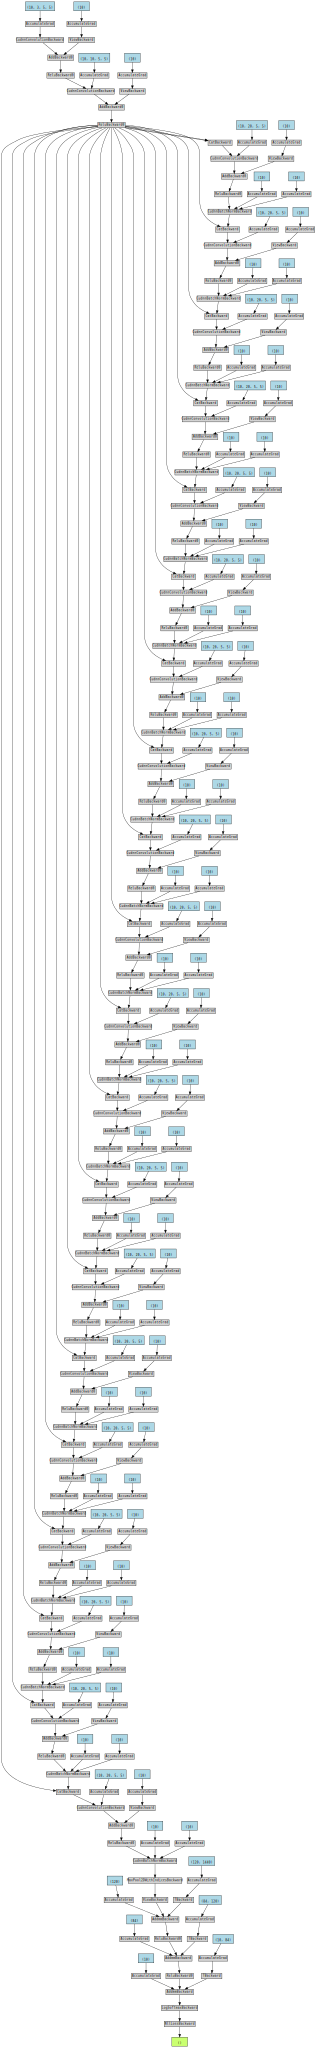

In [86]:
make_dot(loss)

# Co tak naprawdę robią CNN

In [18]:
def plot_filters_multi_channel(t):
    
    #get the number of kernels
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for index_i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows, num_cols, index_i + 1)
        
        #for each kernel, we convert the tensor to numpy 
        np_img = np.array(t[index_i].numpy(), np.float32)
        #standardize the numpy image
        np_img = (np_img - np.mean(np_img)) / np.std(np_img)
        np_img = np.minimum(1, np.maximum(0, (np_img + 0.5)))
        np_img = np_img.transpose((1, 2, 0))
        ax1.imshow(np_img)
        ax1.axis('off')
        ax1.set_title(str(index_i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
#     plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [19]:
import seaborn as sns

In [20]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/1, nrows/20))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [21]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [22]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
    #extracting the model features at the particular layer number
    layer = model.features[layer_num]

    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data

        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)

        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                plot_filters_multi_channel(weight_tensor[:,:3,:,:])
                print("Plot limited to first 3 channels only")

    else:
        print("Can only visualize layers which are convolutional")

In [23]:
alexnet = models.alexnet(pretrained=True)

In [24]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

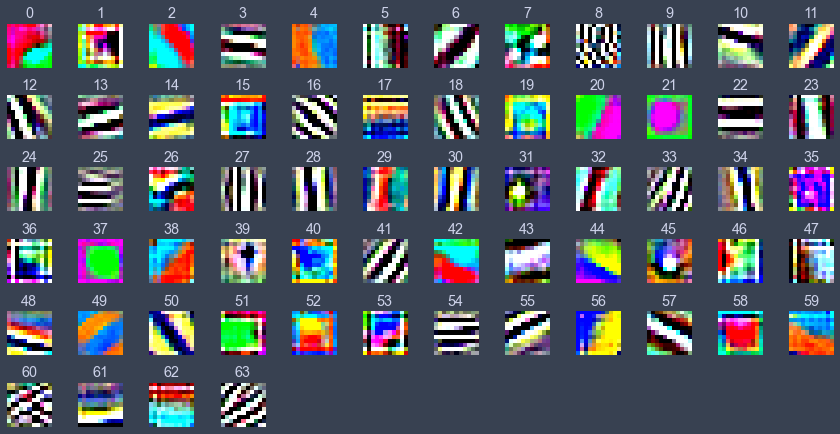

In [25]:
plot_weights(alexnet, 0, single_channel = False)

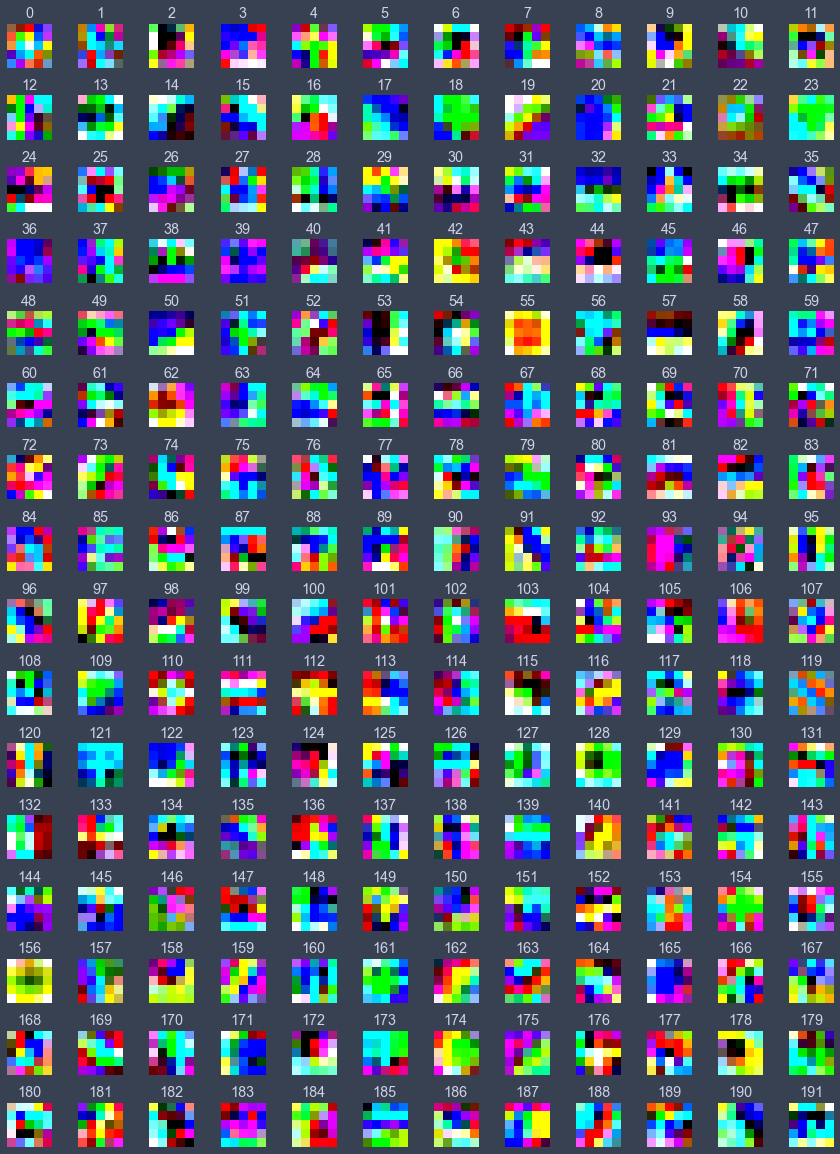

Plot limited to first 3 channels only


In [26]:
plot_weights(alexnet, 3, single_channel = False)

## Zadanie
+ Znalezienie błędów i naprawienie modelu tak żeby działał i uczył się na zbiorze fashionMNIST. 
+ Podpowiedź: https://twitter.com/ylecun/status/1459943933027487744

In [56]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 128

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

+ Rozmiar wejscia:
    + rozmiar batcha - 32
    + kanalow - 1
    + obrazki o wymiarach 28x28

In [57]:
next(iter(testloader))[0].shape

torch.Size([128, 1, 28, 28])

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class FashionNet(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=25, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(25)
        ## Warstwa max pooling
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=(2,2))
        # 13
        self.conv2 = nn.Conv2d(in_channels=25, out_channels=20, kernel_size=2)
        self.bn2 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        # 11

        self.fc1 = nn.Linear(20 * 11 * 11, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.bn1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.bn2(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x


net = FashionNet().to(device)
net

FashionNet(
  (conv1): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(25, 20, kernel_size=(2, 2), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2420, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [59]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [60]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1/5] loss: 0.096
[2/5] loss: 0.066
[3/5] loss: 0.057
[4/5] loss: 0.053
[5/5] loss: 0.050
Finished Training


In [61]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test images: {}'.format(len(testloader),100 * correct / total))

Accuracy of the network on the 79 test images: 89.54
